In [1]:
2*3


6

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [13]:
!pip install optuna

In [14]:
import optuna

In [15]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
cols_with_missing_values = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_missing_values] = df[cols_with_missing_values].replace(0, np.nan)


# replacing the nan values with mean
df.fillna(df.mean(), inplace=True)

In [17]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [53]:
X = df.iloc[:, :-1].values  # X label - selecting whole df except the last head(Out
# come)
Y = df.iloc[:, -1].values   # Y label - slecting the outcomes

#splitting data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

In [54]:
# Normalizing the dataframe for better results
# StandardScarler ====>  removing mean and scalling to unit variance ==> (x - mean) / variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [55]:
def objective(trial):
    # Hyperparameters to tune
    neurons_1 = trial.suggest_int('neurons_1', 16, 128)
    neurons_2 = trial.suggest_int('neurons_2', 8, 64)
    neurons_3 = trial.suggest_int('neurons_3', 4, 32)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons_2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons_3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0005)  # Reduced learning rate for stability
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, Y_train, epochs=150, batch_size=60, validation_data=(X_test, Y_test), verbose=1)

    # Make predictions and calculate F1 score
    Y_pred_probs = model.predict(X_test)
    Y_pred_classes = (Y_pred_probs > 0.5).astype(int)
    f1 = f1_score(Y_test, Y_pred_classes)



    return f1


In [56]:
# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize the F1 score
study.optimize(objective, n_trials=25)  # Number of trials to run



[I 2025-02-03 08:41:52,704] A new study created in memory with name: no-name-6ffdc878-0b66-4e00-b2d7-650e419f8bc8


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.3588 - loss: 0.8036 - val_accuracy: 0.3571 - val_loss: 0.7495
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3558 - loss: 0.8343 - val_accuracy: 0.3571 - val_loss: 0.7492
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3580 - loss: 0.8176 - val_accuracy: 0.3571 - val_loss: 0.7489
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3591 - loss: 0.8011 - val_accuracy: 0.3571 - val_loss: 0.7486
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3768 - loss: 0.8004 - val_accuracy: 0.3571 - val_loss: 0.7483
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3656 - loss: 0.8174 - val_accuracy: 0.3571 - val_loss: 0.7481
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3298 - loss: 0.8177 - val_accuracy: 0.3571 - val_loss: 0.7478
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3901 - loss: 0.8042 - val_accuracy: 0.3571 - val_loss: 0.747

[I 2025-02-03 08:42:10,548] Trial 0 finished with value: 0.5217391304347826 and parameters: {'neurons_1': 17, 'neurons_2': 33, 'neurons_3': 17, 'dropout_rate': 0.48085619862571344, 'learning_rate': 4.73395496043382e-06, 'l2_reg': 1.587501761600353e-06}. Best is trial 0 with value: 0.5217391304347826.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.6221 - loss: 0.7114 - val_accuracy: 0.5584 - val_loss: 0.7273
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6348 - loss: 0.7126 - val_accuracy: 0.5649 - val_loss: 0.7269
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6363 - loss: 0.7059 - val_accuracy: 0.5649 - val_loss: 0.7265
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5985 - loss: 0.7202 - val_accuracy: 0.5649 - val_loss: 0.7261
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6266 - loss: 0.7050 - val_accuracy: 0.5714 - val_loss: 0.7257
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6261 - loss: 0.7118 - val_accuracy: 0.5714 - val_loss: 0.7253
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6245 - loss: 0.7144 - val_accuracy: 0.5714 - val_loss: 0.7250
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6305 - loss: 0.7053 - val_accuracy: 0.5779 - val_loss: 0

[I 2025-02-03 08:42:25,063] Trial 1 finished with value: 0.35 and parameters: {'neurons_1': 61, 'neurons_2': 18, 'neurons_3': 14, 'dropout_rate': 0.34213455896204936, 'learning_rate': 9.023144687182362e-06, 'l2_reg': 0.0006785776225922095}. Best is trial 0 with value: 0.5217391304347826.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.4285 - loss: 0.7278 - val_accuracy: 0.3896 - val_loss: 0.7230
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4251 - loss: 0.7246 - val_accuracy: 0.3961 - val_loss: 0.7225
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4595 - loss: 0.7241 - val_accuracy: 0.3961 - val_loss: 0.7219
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4515 - loss: 0.7149 - val_accuracy: 0.3961 - val_loss: 0.7213
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4185 - loss: 0.7249 - val_accuracy: 0.3961 - val_loss: 0.7208
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4112 - loss: 0.7188 - val_accuracy: 0.3961 - val_loss: 0.7202
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4262 - loss: 0.7262 - val_accuracy: 0.3961 - val_loss: 0.7196
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4454 - loss: 0.7201 - val_accuracy: 0.3831 - val_loss: 0.7191


[I 2025-02-03 08:42:39,832] Trial 2 finished with value: 0.5142857142857142 and parameters: {'neurons_1': 84, 'neurons_2': 26, 'neurons_3': 30, 'dropout_rate': 0.3923687534559872, 'learning_rate': 9.688293206086544e-06, 'l2_reg': 5.327479930551335e-06}. Best is trial 0 with value: 0.5217391304347826.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.6174 - loss: 0.7172 - val_accuracy: 0.5649 - val_loss: 0.7446
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6169 - loss: 0.7285 - val_accuracy: 0.5649 - val_loss: 0.7445
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5895 - loss: 0.7261 - val_accuracy: 0.5649 - val_loss: 0.7444
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5733 - loss: 0.7409 - val_accuracy: 0.5649 - val_loss: 0.7443
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5948 - loss: 0.7269 - val_accuracy: 0.5649 - val_loss: 0.7442
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6270 - loss: 0.7119 - val_accuracy: 0.5714 - val_loss: 0.7441
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5945 - loss: 0.7278 - val_accuracy: 0.5714 - val_loss: 0.7440
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5658 - loss: 0.7410 - val_accuracy: 0.5714 - val_loss: 0.7439


[I 2025-02-03 08:42:54,551] Trial 3 finished with value: 0.0 and parameters: {'neurons_1': 86, 'neurons_2': 53, 'neurons_3': 15, 'dropout_rate': 0.30340281527783436, 'learning_rate': 1.0130504585263496e-06, 'l2_reg': 7.143885226755079e-05}. Best is trial 0 with value: 0.5217391304347826.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.5871 - loss: 0.7096 - val_accuracy: 0.6429 - val_loss: 0.6684
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5947 - loss: 0.7042 - val_accuracy: 0.6429 - val_loss: 0.6682
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6311 - loss: 0.6771 - val_accuracy: 0.6429 - val_loss: 0.6680
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6007 - loss: 0.6846 - val_accuracy: 0.6429 - val_loss: 0.6679
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6424 - loss: 0.6672 - val_accuracy: 0.6429 - val_loss: 0.6677
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6185 - loss: 0.6847 - val_accuracy: 0.6429 - val_loss: 0.6675
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6351 - loss: 0.6821 - val_accuracy: 0.6429 - val_loss: 0.6673
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6233 - loss: 0.6720 - val_accuracy: 0.6429 - val_loss: 0.6671


[I 2025-02-03 08:43:14,625] Trial 4 finished with value: 0.16129032258064516 and parameters: {'neurons_1': 125, 'neurons_2': 50, 'neurons_3': 12, 'dropout_rate': 0.39165432952279444, 'learning_rate': 1.913321444579823e-06, 'l2_reg': 6.851805880648588e-05}. Best is trial 0 with value: 0.5217391304347826.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.4174 - loss: 0.7350 - val_accuracy: 0.4870 - val_loss: 0.6929
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4524 - loss: 0.7200 - val_accuracy: 0.4935 - val_loss: 0.6926
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4686 - loss: 0.7176 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4426 - loss: 0.7190 - val_accuracy: 0.5065 - val_loss: 0.6921
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4346 - loss: 0.7237 - val_accuracy: 0.5065 - val_loss: 0.6919
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4463 - loss: 0.7212 - val_accuracy: 0.5130 - val_loss: 0.6916
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4541 - loss: 0.7182 - val_accuracy: 0.5195 - val_loss: 0.6914
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4290 - loss: 0.7297 - val_accuracy: 0.5325 - val_loss: 0.6911


[I 2025-02-03 08:43:35,235] Trial 5 finished with value: 0.6419753086419753 and parameters: {'neurons_1': 118, 'neurons_2': 55, 'neurons_3': 29, 'dropout_rate': 0.4230983201967649, 'learning_rate': 2.9154740255275342e-06, 'l2_reg': 2.739874300433635e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.3787 - loss: 0.7418 - val_accuracy: 0.4740 - val_loss: 0.7132
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4052 - loss: 0.7363 - val_accuracy: 0.4805 - val_loss: 0.7130
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4080 - loss: 0.7357 - val_accuracy: 0.4805 - val_loss: 0.7128
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4006 - loss: 0.7406 - val_accuracy: 0.4740 - val_loss: 0.7125
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4143 - loss: 0.7339 - val_accuracy: 0.4740 - val_loss: 0.7123
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4294 - loss: 0.7325 - val_accuracy: 0.4740 - val_loss: 0.7121
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4122 - loss: 0.7362 - val_accuracy: 0.4740 - val_loss: 0.7119
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3814 - loss: 0.7433 - val_accuracy: 0.4740 - val_loss: 0.7117


[I 2025-02-03 08:43:54,466] Trial 6 finished with value: 0.5853658536585366 and parameters: {'neurons_1': 128, 'neurons_2': 13, 'neurons_3': 25, 'dropout_rate': 0.3176711448093195, 'learning_rate': 5.63684247355831e-06, 'l2_reg': 0.00033361394659517005}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.4671 - loss: 0.7435 - val_accuracy: 0.3961 - val_loss: 0.7097
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4422 - loss: 0.7326 - val_accuracy: 0.3961 - val_loss: 0.7096
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4741 - loss: 0.7276 - val_accuracy: 0.3961 - val_loss: 0.7095
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4758 - loss: 0.7394 - val_accuracy: 0.3961 - val_loss: 0.7095
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4556 - loss: 0.7349 - val_accuracy: 0.3961 - val_loss: 0.7094
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4264 - loss: 0.7444 - val_accuracy: 0.3961 - val_loss: 0.7093
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4889 - loss: 0.6979 - val_accuracy: 0.3961 - val_loss: 0.7092
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4942 - loss: 0.7256 - val_accuracy: 0.3961 - val_loss: 0.7091

[I 2025-02-03 08:44:08,977] Trial 7 finished with value: 0.5108695652173914 and parameters: {'neurons_1': 43, 'neurons_2': 35, 'neurons_3': 8, 'dropout_rate': 0.4512886705431343, 'learning_rate': 2.3537301098682484e-06, 'l2_reg': 1.9539118334033602e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.6143 - loss: 0.7247 - val_accuracy: 0.6299 - val_loss: 0.7227
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6040 - loss: 0.7458 - val_accuracy: 0.6299 - val_loss: 0.7226
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6275 - loss: 0.7222 - val_accuracy: 0.6299 - val_loss: 0.7224
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6106 - loss: 0.7387 - val_accuracy: 0.6299 - val_loss: 0.7223
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6445 - loss: 0.7113 - val_accuracy: 0.6299 - val_loss: 0.7221
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6578 - loss: 0.7114 - val_accuracy: 0.6299 - val_loss: 0.7220
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6372 - loss: 0.7170 - val_accuracy: 0.6299 - val_loss: 0.7219
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6053 - loss: 0.7288 - val_accuracy: 0.6299 - val_loss: 0.721

[I 2025-02-03 08:44:25,144] Trial 8 finished with value: 0.0 and parameters: {'neurons_1': 22, 'neurons_2': 36, 'neurons_3': 30, 'dropout_rate': 0.36581552678150225, 'learning_rate': 3.3990072390765566e-06, 'l2_reg': 0.0006448551148729186}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.4196 - loss: 0.7279 - val_accuracy: 0.3766 - val_loss: 0.7149
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4071 - loss: 0.7255 - val_accuracy: 0.3766 - val_loss: 0.7148
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4149 - loss: 0.7369 - val_accuracy: 0.3766 - val_loss: 0.7147
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4313 - loss: 0.7222 - val_accuracy: 0.3766 - val_loss: 0.7145
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4191 - loss: 0.7215 - val_accuracy: 0.3766 - val_loss: 0.7144
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4503 - loss: 0.7165 - val_accuracy: 0.3766 - val_loss: 0.7143
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3913 - loss: 0.7367 - val_accuracy: 0.3766 - val_loss: 0.7142
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4141 - loss: 0.7274 - val_accuracy: 0.3766 - val_loss: 0.7140

[I 2025-02-03 08:44:40,337] Trial 9 finished with value: 0.48044692737430167 and parameters: {'neurons_1': 70, 'neurons_2': 13, 'neurons_3': 31, 'dropout_rate': 0.443278165994308, 'learning_rate': 2.948074647972704e-06, 'l2_reg': 4.231842688884482e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.5851 - loss: 0.6838 - val_accuracy: 0.6234 - val_loss: 0.6885
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5803 - loss: 0.6728 - val_accuracy: 0.6234 - val_loss: 0.6884
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5773 - loss: 0.6913 - val_accuracy: 0.6234 - val_loss: 0.6883
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6098 - loss: 0.6757 - val_accuracy: 0.6234 - val_loss: 0.6882
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5788 - loss: 0.6887 - val_accuracy: 0.6234 - val_loss: 0.6881
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5896 - loss: 0.6838 - val_accuracy: 0.6234 - val_loss: 0.6880
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6016 - loss: 0.6908 - val_accuracy: 0.6234 - val_loss: 0.6879
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5836 - loss: 0.6913 - val_accuracy: 0.6234 - val_loss: 0.687

[I 2025-02-03 08:44:54,322] Trial 10 finished with value: 0.03389830508474576 and parameters: {'neurons_1': 104, 'neurons_2': 60, 'neurons_3': 21, 'dropout_rate': 0.43167345928187933, 'learning_rate': 1.5070137263760269e-06, 'l2_reg': 9.688572804107265e-06}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.6187 - loss: 0.6854 - val_accuracy: 0.6169 - val_loss: 0.6833
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6528 - loss: 0.6812 - val_accuracy: 0.6169 - val_loss: 0.6830
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6486 - loss: 0.6723 - val_accuracy: 0.6169 - val_loss: 0.6828
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6612 - loss: 0.6799 - val_accuracy: 0.6169 - val_loss: 0.6825
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6472 - loss: 0.6768 - val_accuracy: 0.6169 - val_loss: 0.6823
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6801 - loss: 0.6830 - val_accuracy: 0.6169 - val_loss: 0.6820
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6412 - loss: 0.6890 - val_accuracy: 0.6234 - val_loss: 0.6818
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6408 - loss: 0.6846 - val_accuracy: 0.6234 - val_loss: 0.681

[I 2025-02-03 08:45:08,510] Trial 11 finished with value: 0.43010752688172044 and parameters: {'neurons_1': 127, 'neurons_2': 8, 'neurons_3': 24, 'dropout_rate': 0.3043229243636521, 'learning_rate': 5.344663882158247e-06, 'l2_reg': 0.0002501608898310151}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.3968 - loss: 0.7358 - val_accuracy: 0.4156 - val_loss: 0.7100
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3769 - loss: 0.7563 - val_accuracy: 0.4221 - val_loss: 0.7095
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4059 - loss: 0.7458 - val_accuracy: 0.4221 - val_loss: 0.7089
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3987 - loss: 0.7506 - val_accuracy: 0.4286 - val_loss: 0.7084
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4129 - loss: 0.7385 - val_accuracy: 0.4286 - val_loss: 0.7078
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4008 - loss: 0.7474 - val_accuracy: 0.4286 - val_loss: 0.7073
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4332 - loss: 0.7361 - val_accuracy: 0.4286 - val_loss: 0.7068
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4023 - loss: 0.7380 - val_accuracy: 0.4351 - val_loss: 0.7063

[I 2025-02-03 08:45:28,854] Trial 12 finished with value: 0.6125 and parameters: {'neurons_1': 107, 'neurons_2': 48, 'neurons_3': 24, 'dropout_rate': 0.35278837837378824, 'learning_rate': 5.170352906680387e-06, 'l2_reg': 0.00013083578011830106}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.5377 - loss: 0.7025 - val_accuracy: 0.6039 - val_loss: 0.6927
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5183 - loss: 0.7058 - val_accuracy: 0.6039 - val_loss: 0.6923
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5131 - loss: 0.7119 - val_accuracy: 0.6039 - val_loss: 0.6919
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5501 - loss: 0.7056 - val_accuracy: 0.6039 - val_loss: 0.6915
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5062 - loss: 0.7146 - val_accuracy: 0.6104 - val_loss: 0.6911
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5201 - loss: 0.7065 - val_accuracy: 0.6104 - val_loss: 0.6907
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5447 - loss: 0.7114 - val_accuracy: 0.6104 - val_loss: 0.6903
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5593 - loss: 0.6956 - val_accuracy: 0.6104 - val_loss: 0.6899

[I 2025-02-03 08:45:47,864] Trial 13 finished with value: 0.3037974683544304 and parameters: {'neurons_1': 103, 'neurons_2': 47, 'neurons_3': 26, 'dropout_rate': 0.36052552516759095, 'learning_rate': 3.959055928026116e-06, 'l2_reg': 0.00012184455474627369}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.4956 - loss: 0.7024 - val_accuracy: 0.5325 - val_loss: 0.6862
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4548 - loss: 0.7298 - val_accuracy: 0.5325 - val_loss: 0.6857
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4731 - loss: 0.7120 - val_accuracy: 0.5455 - val_loss: 0.6853
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4493 - loss: 0.7296 - val_accuracy: 0.5455 - val_loss: 0.6848
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4433 - loss: 0.7239 - val_accuracy: 0.5455 - val_loss: 0.6844
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4579 - loss: 0.7190 - val_accuracy: 0.5455 - val_loss: 0.6839
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4172 - loss: 0.7242 - val_accuracy: 0.5519 - val_loss: 0.6834
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4887 - loss: 0.6953 - val_accuracy: 0.5519 - val_loss: 0.683

[I 2025-02-03 08:46:08,391] Trial 14 finished with value: 0.6165413533834586 and parameters: {'neurons_1': 106, 'neurons_2': 44, 'neurons_3': 20, 'dropout_rate': 0.42056859023455606, 'learning_rate': 6.46708402561259e-06, 'l2_reg': 1.93168608444279e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.6518 - loss: 0.6408 - val_accuracy: 0.6429 - val_loss: 0.6457
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6561 - loss: 0.6499 - val_accuracy: 0.6429 - val_loss: 0.6452
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6050 - loss: 0.6542 - val_accuracy: 0.6429 - val_loss: 0.6447
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6149 - loss: 0.6586 - val_accuracy: 0.6429 - val_loss: 0.6442
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6496 - loss: 0.6532 - val_accuracy: 0.6429 - val_loss: 0.6437
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6120 - loss: 0.6561 - val_accuracy: 0.6429 - val_loss: 0.6432
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6530 - loss: 0.6486 - val_accuracy: 0.6429 - val_loss: 0.6427
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6328 - loss: 0.6519 - val_accuracy: 0.6429 - val_loss: 0.6

[I 2025-02-03 08:46:23,853] Trial 15 finished with value: 0.0 and parameters: {'neurons_1': 111, 'neurons_2': 60, 'neurons_3': 20, 'dropout_rate': 0.4181091228081321, 'learning_rate': 6.677042305898976e-06, 'l2_reg': 1.5055813797310229e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - accuracy: 0.6003 - loss: 0.6624 - val_accuracy: 0.6429 - val_loss: 0.6678
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6320 - loss: 0.6779 - val_accuracy: 0.6429 - val_loss: 0.6678
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6196 - loss: 0.6788 - val_accuracy: 0.6429 - val_loss: 0.6677
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6078 - loss: 0.6793 - val_accuracy: 0.6429 - val_loss: 0.6676
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6137 - loss: 0.6734 - val_accuracy: 0.6429 - val_loss: 0.6675
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5973 - loss: 0.6805 - val_accuracy: 0.6429 - val_loss: 0.6674
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5706 - loss: 0.6808 - val_accuracy: 0.6429 - val_loss: 0.6673
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6263 - loss: 0.6698 - val_accuracy: 0.6429 - val_loss: 0.6672

[I 2025-02-03 08:46:44,234] Trial 16 finished with value: 0.0 and parameters: {'neurons_1': 91, 'neurons_2': 43, 'neurons_3': 6, 'dropout_rate': 0.47565680444759606, 'learning_rate': 2.810012715770473e-06, 'l2_reg': 5.541386715471476e-06}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.5925 - loss: 0.6729 - val_accuracy: 0.6299 - val_loss: 0.6713
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5747 - loss: 0.6788 - val_accuracy: 0.6364 - val_loss: 0.6706
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5706 - loss: 0.6724 - val_accuracy: 0.6558 - val_loss: 0.6698
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5751 - loss: 0.6729 - val_accuracy: 0.6558 - val_loss: 0.6691
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5892 - loss: 0.6769 - val_accuracy: 0.6688 - val_loss: 0.6683
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6290 - loss: 0.6667 - val_accuracy: 0.6688 - val_loss: 0.6675
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6207 - loss: 0.6643 - val_accuracy: 0.6688 - val_loss: 0.6668
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5758 - loss: 0.6665 - val_accuracy: 0.6688 - val_loss: 0.6662


[I 2025-02-03 08:46:59,173] Trial 17 finished with value: 0.5523809523809524 and parameters: {'neurons_1': 94, 'neurons_2': 56, 'neurons_3': 28, 'dropout_rate': 0.41566575342043194, 'learning_rate': 6.9529035963780646e-06, 'l2_reg': 1.5432293430558706e-06}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.6407 - loss: 0.6782 - val_accuracy: 0.6948 - val_loss: 0.6696
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6165 - loss: 0.6704 - val_accuracy: 0.6948 - val_loss: 0.6695
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6340 - loss: 0.6704 - val_accuracy: 0.6948 - val_loss: 0.6695
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6549 - loss: 0.6620 - val_accuracy: 0.6948 - val_loss: 0.6694
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6332 - loss: 0.6657 - val_accuracy: 0.6948 - val_loss: 0.6693
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6551 - loss: 0.6745 - val_accuracy: 0.6948 - val_loss: 0.6692
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6498 - loss: 0.6591 - val_accuracy: 0.6948 - val_loss: 0.6692
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6424 - loss: 0.6631 - val_accuracy: 0.6948 - val_loss: 0.669

[I 2025-02-03 08:47:13,699] Trial 18 finished with value: 0.28125 and parameters: {'neurons_1': 116, 'neurons_2': 41, 'neurons_3': 20, 'dropout_rate': 0.49649020446715186, 'learning_rate': 1.969380966148601e-06, 'l2_reg': 2.794186778343176e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.5792 - loss: 0.6767 - val_accuracy: 0.6299 - val_loss: 0.6968
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6454 - loss: 0.6748 - val_accuracy: 0.6299 - val_loss: 0.6965
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5580 - loss: 0.6825 - val_accuracy: 0.6299 - val_loss: 0.6962
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5802 - loss: 0.6787 - val_accuracy: 0.6299 - val_loss: 0.6960
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5792 - loss: 0.6785 - val_accuracy: 0.6299 - val_loss: 0.6957
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5942 - loss: 0.6718 - val_accuracy: 0.6299 - val_loss: 0.6955
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5552 - loss: 0.6886 - val_accuracy: 0.6299 - val_loss: 0.6953
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5876 - loss: 0.6772 - val_accuracy: 0.6299 - val_loss: 0.6950


[I 2025-02-03 08:47:33,920] Trial 19 finished with value: 0.0967741935483871 and parameters: {'neurons_1': 56, 'neurons_2': 62, 'neurons_3': 10, 'dropout_rate': 0.45518076172380373, 'learning_rate': 3.883227003332321e-06, 'l2_reg': 3.7749178369087994e-06}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.6403 - loss: 0.6620 - val_accuracy: 0.6494 - val_loss: 0.6626
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6320 - loss: 0.6630 - val_accuracy: 0.6494 - val_loss: 0.6626
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6264 - loss: 0.6688 - val_accuracy: 0.6494 - val_loss: 0.6625
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6340 - loss: 0.6602 - val_accuracy: 0.6494 - val_loss: 0.6624
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6766 - loss: 0.6557 - val_accuracy: 0.6494 - val_loss: 0.6623
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6714 - loss: 0.6553 - val_accuracy: 0.6494 - val_loss: 0.6623
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6574 - loss: 0.6564 - val_accuracy: 0.6494 - val_loss: 0.6622
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6157 - loss: 0.6679 - val_accuracy: 0.6494 - val_loss: 0.6622

[I 2025-02-03 08:47:53,190] Trial 20 finished with value: 0.20588235294117646 and parameters: {'neurons_1': 117, 'neurons_2': 26, 'neurons_3': 27, 'dropout_rate': 0.39317916456634894, 'learning_rate': 1.42101722588466e-06, 'l2_reg': 1.0665404489619925e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.3972 - loss: 0.7429 - val_accuracy: 0.3701 - val_loss: 0.7266
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4258 - loss: 0.7353 - val_accuracy: 0.3701 - val_loss: 0.7259
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3844 - loss: 0.7427 - val_accuracy: 0.3766 - val_loss: 0.7252
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3806 - loss: 0.7420 - val_accuracy: 0.3831 - val_loss: 0.7246
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4391 - loss: 0.7317 - val_accuracy: 0.3831 - val_loss: 0.7239
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4261 - loss: 0.7395 - val_accuracy: 0.3831 - val_loss: 0.7233
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4140 - loss: 0.7348 - val_accuracy: 0.3831 - val_loss: 0.7227
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4318 - loss: 0.7245 - val_accuracy: 0.3831 - val_loss: 0.7220
E

[I 2025-02-03 08:48:14,047] Trial 21 finished with value: 0.6107784431137725 and parameters: {'neurons_1': 102, 'neurons_2': 46, 'neurons_3': 23, 'dropout_rate': 0.36046995096630857, 'learning_rate': 7.276898997199754e-06, 'l2_reg': 0.00013346274044384707}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.3822 - loss: 0.7849 - val_accuracy: 0.3896 - val_loss: 0.7328
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3834 - loss: 0.7761 - val_accuracy: 0.3896 - val_loss: 0.7322
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3766 - loss: 0.7820 - val_accuracy: 0.3896 - val_loss: 0.7315
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3829 - loss: 0.7911 - val_accuracy: 0.3896 - val_loss: 0.7309
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4165 - loss: 0.7747 - val_accuracy: 0.3896 - val_loss: 0.7303
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4201 - loss: 0.7608 - val_accuracy: 0.3896 - val_loss: 0.7296
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4296 - loss: 0.7688 - val_accuracy: 0.3896 - val_loss: 0.7290
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3961 - loss: 0.7859 - val_accuracy: 0.3896 - val_loss: 0.7284


[I 2025-02-03 08:48:34,422] Trial 22 finished with value: 0.547486033519553 and parameters: {'neurons_1': 75, 'neurons_2': 54, 'neurons_3': 22, 'dropout_rate': 0.41051904052220245, 'learning_rate': 4.623936878679531e-06, 'l2_reg': 3.842909106277886e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.4149 - loss: 0.7240 - val_accuracy: 0.3896 - val_loss: 0.7203
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3977 - loss: 0.7358 - val_accuracy: 0.3896 - val_loss: 0.7199
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4211 - loss: 0.7305 - val_accuracy: 0.3831 - val_loss: 0.7196
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4437 - loss: 0.7247 - val_accuracy: 0.3831 - val_loss: 0.7192
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4217 - loss: 0.7264 - val_accuracy: 0.3831 - val_loss: 0.7188
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4379 - loss: 0.7300 - val_accuracy: 0.3831 - val_loss: 0.7184
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4100 - loss: 0.7338 - val_accuracy: 0.3831 - val_loss: 0.7181
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4080 - loss: 0.7341 - val_accuracy: 0.3831 - val_loss: 0.7177


[I 2025-02-03 08:48:50,021] Trial 23 finished with value: 0.5698324022346368 and parameters: {'neurons_1': 111, 'neurons_2': 40, 'neurons_3': 18, 'dropout_rate': 0.3727282601609965, 'learning_rate': 6.003411369202704e-06, 'l2_reg': 6.901362524043401e-05}. Best is trial 5 with value: 0.6419753086419753.


Epoch 1/50


<ipython-input-55-5c3deb0949fd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
<ipython-input-55-5c3deb0949fd>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
<ipython-input-55-5c3deb0949fd>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an 

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - accuracy: 0.4204 - loss: 0.7430 - val_accuracy: 0.4221 - val_loss: 0.7385
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4183 - loss: 0.7435 - val_accuracy: 0.4481 - val_loss: 0.7379
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4210 - loss: 0.7467 - val_accuracy: 0.4481 - val_loss: 0.7373
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4498 - loss: 0.7393 - val_accuracy: 0.4545 - val_loss: 0.7366
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4310 - loss: 0.7438 - val_accuracy: 0.4545 - val_loss: 0.7360
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4645 - loss: 0.7388 - val_accuracy: 0.4610 - val_loss: 0.7354
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4255 - loss: 0.7407 - val_accuracy: 0.4610 - val_loss: 0.7348
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4249 - loss: 0.7356 - val_accuracy: 0.4675 - val_loss: 0.7342

[I 2025-02-03 08:49:12,886] Trial 24 finished with value: 0.18666666666666668 and parameters: {'neurons_1': 97, 'neurons_2': 49, 'neurons_3': 28, 'dropout_rate': 0.33843748141125973, 'learning_rate': 7.749008829152038e-06, 'l2_reg': 0.0001612133738749933}. Best is trial 5 with value: 0.6419753086419753.


In [57]:
# After optimization, retrieve the best hyperparameters and retrain the model
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Retrain with the best hyperparameters
model = tf.keras.Sequential([
    tf.keras.layers.Dense(best_params['neurons_1'], activation='relu', kernel_regularizer=regularizers.l2(best_params['l2_reg']), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(best_params['dropout_rate']),
    tf.keras.layers.Dense(best_params['neurons_2'], activation='relu', kernel_regularizer=regularizers.l2(best_params['l2_reg'])),
    tf.keras.layers.Dropout(best_params['dropout_rate']),
    tf.keras.layers.Dense(best_params['neurons_3'], activation='relu', kernel_regularizer=regularizers.l2(best_params['l2_reg'])),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the final model with the best hyperparameters
trained = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Make final predictions
Y_pred_probs = model.predict(X_test)
Y_pred_classes = (Y_pred_probs > 0.5).astype(int)

# Calculate recall, precision, F1 score, and accuracy with the best model
recall = recall_score(Y_test, Y_pred_classes)
precision = precision_score(Y_test, Y_pred_classes)
f1 = f1_score(Y_test, Y_pred_classes)
accuracy = accuracy_score(Y_test, Y_pred_classes)

# Print all metrics
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy at classification threshold: {accuracy:.3f}")

Best hyperparameters: {'neurons_1': 118, 'neurons_2': 55, 'neurons_3': 29, 'dropout_rate': 0.4230983201967649, 'learning_rate': 2.9154740255275342e-06, 'l2_reg': 2.739874300433635e-05}
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.5137 - loss: 0.6979 - val_accuracy: 0.5844 - val_loss: 0.6926
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5021 - loss: 0.6992 - val_accuracy: 0.5909 - val_loss: 0.6922
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5413 - loss: 0.6853 - val_accuracy: 0.5974 - val_loss: 0.6919
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5408 - loss: 0.7030 - val_accuracy: 0.5974 - val_loss: 0.6916
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5349 - loss: 0.7071 - val_accuracy: 0.5974 - val_loss: 0.6912
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5358 - loss: 0.6983 - val_accuracy: 0.5974 - val_loss: 0.6909
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4884 - loss: 0.7066 - val_accuracy: 0.5974 - val_loss: 0.6906
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4867 - loss: 0.6974 - val_accuracy: 0.5974 - val_loss

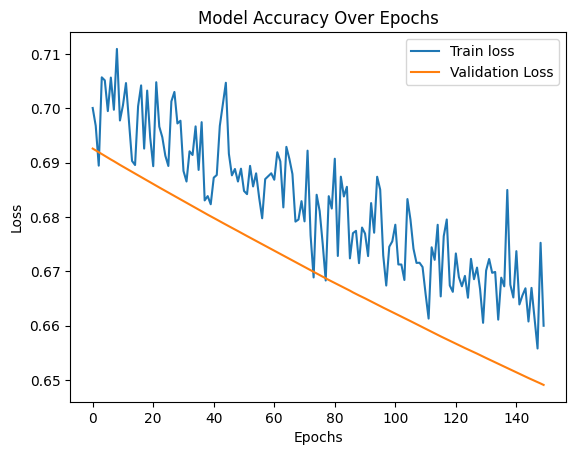

In [58]:
import matplotlib.pyplot as plt

plt.plot(trained.history['loss'], label='Train loss')
plt.plot(trained.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# overfitting